# About me

* Cristian Lungu, Phd.c. UTCN, AI
* ML Researcher, Trainer, Consultant 
* www.clungu.com

# Intuition

Everypresentation starts with a cat

![image.png](https://r.hswstatic.com/w_907/gif/tesla-cat.jpg)

If I show you one, what do you see?

* has fur
* black eyes
* two ears
* sits
* looks away from the camera


* small 
* mamal
* likes to cuddle
* eats mice
...

# Maths embeddings

In mathematics, an embedding (or imbedding[1]) is one instance of some mathematical structure contained within another instance, such as a group that is a subgroup. (wikipedia)

.... (!)

In IT we say it's a mapping (form A to B)

# Embeddings as expansions 

The first use-case (and arguably the most common one) is expanding an element into some semantic values (latent variables).

## Word embeddings

We will try to attach for each word, a "meaning" (a semantic context). 
We interpret "context" as whatever words are, before (or after our target word). So we will get a dataset that parses free text, and slides a window of a certain size over the full text.

In this example we're going to use:
* 3 words sized window, 1 word prediction

ETL.. get the data, process it and load it in a specific format

In [20]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt 

from scipy import io
from keras.utils.np_utils import to_categorical

mat = io.loadmat("/home/cristi/Applications/GITHub/keras/tensor_flow/data/word-embeddings.mat")
data = mat['data']['trainData'][0][0] - 1 # in octave arrays start from one

vocab = np.array([element[0] for element in mat['data']['vocab'][0][0].reshape(250)])

inputs = data[:3, :].T
label_index = data[3, :]
labels = to_categorical(label_index)

Printing some examples, to get a feel of what we are working with

In [3]:
first = 10
list(zip(
    [[vocab[i] for i in words] for words in inputs[:first]], 
    [vocab[l] for l in label_index[:first]]
))

[([u'going', u'to', u'be'], u'.'),
 ([u'were', u'not', u'the'], u'first'),
 ([u'can', u'do', u'for'], u'each'),
 ([u'first', u'time', u'in'], u'my'),
 ([u'nt', u'have', u'the'], u'money'),
 ([u'know', u'what', u'to'], u'do'),
 ([u'i', u'do', u'nt'], u'do'),
 ([u'nt', u'do', u'that'], u'.'),
 ([u'what', u'do', u'you'], u'do'),
 ([u'know', u'is', u'we'], u'are')]

In [4]:
import keras
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import merge, Lambda, Reshape, Dense, BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.layers import Activation
from keras.regularizers import l2

inp_1 = Input(shape=(1,), dtype='int32')
inp_2 = Input(shape=(1,), dtype='int32')
inp_3 = Input(shape=(1,), dtype='int32')

lbl = Input(shape=(1,), dtype='int32')

DIMS = 5
word_emb = Embedding(input_dim=len(vocab), output_dim=(DIMS), W_regularizer=l2(0.0001))

emb_1 = word_emb(inp_1)
emb_2 = word_emb(inp_2)
emb_3 = word_emb(inp_3)

out = Reshape((-1,))(merge([emb_1, emb_2, emb_3], mode='concat'))
out = Dense(output_dim=len(vocab), activation='softmax')(out)
word_model = Model(input=[inp_1, inp_2, inp_3], output=out)
word_model.compile(optimizer='adam', loss='categorical_crossentropy')
word_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 5)          1250        input_1[0][0]                    
                                                                   input_2[0][0]           

In [5]:
word_model.fit([inputs[:, 0], inputs[:, 1], inputs[:, 2]], labels)

Epoch 1/10
372550/372550 [==============================] - 37s - loss: 3.6846    
Epoch 2/10
372550/372550 [==============================] - 37s - loss: 3.3462    
Epoch 3/10
372550/372550 [==============================] - 35s - loss: 3.2946    
Epoch 4/10
372550/372550 [==============================] - 34s - loss: 3.2680    
Epoch 5/10
372550/372550 [==============================] - 34s - loss: 3.2508    
Epoch 6/10
372550/372550 [==============================] - 36s - loss: 3.2389    
Epoch 7/10
372550/372550 [==============================] - 38s - loss: 3.2302    
Epoch 8/10
372550/372550 [==============================] - 38s - loss: 3.2232    
Epoch 9/10
372550/372550 [==============================] - 39s - loss: 3.2177    
Epoch 10/10
372550/372550 [==============================] - 39s - loss: 3.2130    


Building a reversable dictionary

In [6]:
vocab2id = {word: id for id, word in enumerate(vocab)}
assert vocab[vocab2id['going']] == 'going'

Getting the actuall embeddings

In [7]:
embeddings = word_emb.get_weights()[0]

What are the words that are the most similar to one another?

In [72]:
from scipy.spatial.distance import cosine
word = 'going'

def most_similar_words(word):
    t_id = vocab2id[word]
    t_emb = embeddings[t_id]
    return [vocab[id] for id in np.argsort([cosine(t_emb, w_emb) for w_emb in embeddings])[:10]]

most_similar_words('war')

[u'war',
 u'country',
 u'season',
 u'business',
 u'game',
 u'house',
 u'here',
 u'music',
 u'company',
 u'office']

## Word2Vec, Glove

In NLP, the above is just the first thing that you usually do before you want to process text (i.e. substituting words with their embeddings).

Fortunately, there were many attempts (and many companies) that trained word embeddings on large corpuses (and their expense) but made available the results.

Examples of public word embeddinge libraries:
* [Word2Vec](https://code.google.com/archive/p/word2vec/) (Google)
* [GloVe](https://nlp.stanford.edu/projects/glove/) (Stanford)
* [FastText](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) (Facebook)

The most famous one, word2vec has the following two strategies used to training the embeddings:

![image.png](https://raw.githubusercontent.com/rohan-varma/paper-analysis/master/word2vec-papers/models.png)

(Continous Bag of Words), (Skip Gram model)

These embeddings have some pretty cool properties:

![image.png](https://shanelynnwebsite-mid9n9g1q9y8tt.netdna-ssl.com/wp-content/uploads/2018/02/vocabulary-linear-relationships.png)

One downside of embeddings is that they are specific to what they have been trained on.
In this case, english word embeddings are specific, to english and don't relate in any way to embeddings of other languages (except for the fact that distances between equivalent words should have roughtly the same values)

### Same space alligned embeddings

You can also have embeddings alligned in the same vector space

FastText embeddings have a [git repo](https://github.com/Babylonpartners/fastText_multilingual) that you can use to allign all the 190 language embeddings on the same vector space.

One thing that you can use them for is to do a quick, dirty and imperfect transaltion mechanism, where for each word in language A, you take it's embeddings, and search the closest embedding form language B. Having found that embedding you can now substitute it with the word it stands for.

Bellow is a translation done using this mechanism.

```acesta este un text frumos scris```


```lui est un texte plaisant écrit```

## Elemental embeddings

Another use-case for embeddings is expanding your own elements into a "semantic" representation.

We will be using a wine-selection [dataset](https://www.kaggle.com/zynicide/wine-reviews) hosted on Kaggle.

In [9]:
import pandas as pd
from IPython.display import display
table = pd.read_json('./winemag-data-130k-v2.json', encoding = "ISO-8859-1")
display(table.head())

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,None,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,None,None,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",None,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,None,Alexander Peartree,None,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


We're only going to take 'taster_name', 'variety' and 'country' fields into acount.

In [114]:
def count_unique(column_name):
    return len(table[column_name].unique())

count_unique('taster_name'), count_unique('variety'), count_unique('country')

(20, 708, 44)

See that we have values for all the point rows 

In [10]:
import numpy as np
sum(np.isnan(table['points'].values))

0

In [87]:
table['taster_name'].unique()

array([u'Kerin O\u2019Keefe', u'Roger Voss', u'Paul Gregutt',
       u'Alexander Peartree', u'Michael Schachner', u'Anna Lee C. Iijima',
       u'Virginie Boone', u'Matt Kettmann', None, u'Sean P. Sullivan',
       u'Jim Gordon', u'Joe Czerwinski', u'Anne Krebiehl\xa0MW',
       u'Lauren Buzzeo', u'Mike DeSimone', u'Jeff Jenssen',
       u'Susan Kostrzewa', u'Carrie Dykes', u'Fiona Adams',
       u'Christina Pickard'], dtype=object)

Let's make some reversible dictionaries so we can restore the strings from ids and viceversa

In [11]:
taster2id = {taster: id for id, taster in enumerate(table['taster_name'].unique())}
id2taster = {id: taster for id, taster in enumerate(table['taster_name'].unique())}

variety2id = {taster: id for id, taster in enumerate(table['variety'].unique())}
id2variety = {id: taster for id, taster in enumerate(table['variety'].unique())}

country2id = {taster: id for id, taster in enumerate(table['country'].unique())}
id2country = {id: taster for id, taster in enumerate(table['country'].unique())}

Compiling a dataset that has only the above values and uses 'points' as lables

In [12]:
data = np.array([[taster2id[t], variety2id[v], country2id[c]] for t, v, c in table[['taster_name', 'variety', 'country']].values])

labels = table[['points']].values
assert data.shape[0] == labels.shape[0]

# print some examples
list(zip(data[5:10], labels[5:10]))

[(array([4, 5, 3]), array([87])),
 (array([0, 6, 0]), array([87])),
 (array([1, 7, 4]), array([87])),
 (array([5, 7, 5]), array([87])),
 (array([1, 2, 4]), array([87]))]

The embeddings model just translates the element ids into embedded values. We dot product all the permutation and expect that their sum is equal to the predicted price. 

We also add some bias terms to account for the specific 'biases' of each element.

In [13]:
import keras
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import merge, Lambda, Reshape, Dense, BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.layers import Activation
from keras.regularizers import l2

nam_inp = Input(shape=(1,), dtype='int32')
var_inp = Input(shape=(1,), dtype='int32')
cty_inp = Input(shape=(1,), dtype='int32')

DIMS = 10

lbl = Input(shape=(1,), dtype='int32')

nam_emb = Embedding(input_dim=len(taster2id), output_dim=(DIMS), W_regularizer=l2(0.0001))
nam_bis = Embedding(input_dim=len(taster2id), output_dim=1, init='zero')

var_emb = Embedding(input_dim=len(variety2id), output_dim=(DIMS), W_regularizer=l2(0.0001))
var_bis = Embedding(input_dim=len(variety2id), output_dim=1, init='zero')

cty_emb = Embedding(input_dim=len(country2id), output_dim=(DIMS), W_regularizer=l2(0.0001))
cty_bis = Embedding(input_dim=len(country2id), output_dim=1, init='zero')


nam_rsh = BatchNormalization(axis=1)(Reshape((-1, 1))(nam_emb(nam_inp)))
var_rsh = BatchNormalization(axis=1)(Reshape((-1, 1))(var_emb(var_inp)))
cty_rsh = BatchNormalization(axis=1)(Reshape((-1, 1))(cty_emb(cty_inp)))

dot1 = merge([nam_rsh, var_rsh], mode='dot', dot_axes=1)
dot2 = merge([nam_rsh, cty_rsh], mode='dot', dot_axes=1)
dot3 = merge([var_rsh, cty_rsh], mode='dot', dot_axes=1)

dot = merge([dot1, dot2, dot3], mode='sum')

dot = merge([dot, nam_bis(nam_inp)], mode='sum')
dot = merge([dot, var_bis(var_inp)], mode='sum')
dot = merge([dot, cty_bis(cty_inp)], mode='sum')
dot = Reshape((1,))(dot)

out = Activation(activation='relu')(dot)

model = Model([nam_inp, var_inp, cty_inp], out)
model.summary()
model.compile(optimizer='rmsprop', loss='mae')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
input_6 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
input_7 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 10)         200         input_5[0][0]                    
___________________________________________________________________________________________

In [14]:
model.fit([data[:, 0], data[:, 1], data[:, 2]], labels)

Epoch 1/10
129971/129971 [==============================] - 9s - loss: 29.1668     
Epoch 2/10
129971/129971 [==============================] - 8s - loss: 9.4990     
Epoch 3/10
129971/129971 [==============================] - 8s - loss: 3.8390     
Epoch 4/10
129971/129971 [==============================] - 8s - loss: 2.6311     
Epoch 5/10
129971/129971 [==============================] - 8s - loss: 2.4363     
Epoch 6/10
129971/129971 [==============================] - 10s - loss: 2.3623    
Epoch 7/10
129971/129971 [==============================] - 11s - loss: 2.3188    
Epoch 8/10
129971/129971 [==============================] - 9s - loss: 2.2963     
Epoch 9/10
129971/129971 [==============================] - 8s - loss: 2.2824     
Epoch 10/10
129971/129971 [==============================] - 8s - loss: 2.2726     


Trying to extract some meaning from the dimensions

In [153]:
wines = np.array(var_emb.get_weights()[0])

# 0 - being Italian
# 1 - mainstream
# 3 - red-ness
# 8 - Sauvignon / Pinot (sweetness?)
for dimension in range(DIMS):
    print(dimension, [id2variety[v] for v in np.argsort(wines[:, dimension])][:5])

(0, [u'Port', u'Albari\xf1o', u'Cabernet Sauvignon', u'Malbec', u'Nebbiolo'])
(1, [u'Ros\xe9', u'Merlot', u'Cabernet Sauvignon', u'White Blend', u'Viognier'])
(2, [u'Pinot Noir', u'Chardonnay', u'Cabernet Sauvignon', u'Champagne Blend', u'Malbec'])
(3, [u'Bordeaux-style Red Blend', u'Syrah', u'Ros\xe9', u'Red Blend', u'Pinot Noir'])
(4, [u'Pinot Noir', u'Champagne Blend', u'Chardonnay', u'Ros\xe9', u'Viognier'])
(5, [u'Chenin Blanc', u'Pinot Grigio', u'Pinot Blanc', u'Tempranillo Blend', u'Rh\xf4ne-style Red Blend'])
(6, [u'Ros\xe9', u'Red Blend', u'Syrah', u'Viognier', u'Champagne Blend'])
(7, [u'Pinot Noir', u'Chardonnay', u'Ros\xe9', u'Syrah', u'Riesling'])
(8, [u'Cabernet Sauvignon', u'Pinot Blanc', u'Pinot Gris', u'Pinot Noir', u'Sauvignon Blanc'])
(9, [u'Petite Sirah', u'Meritage', u'Glera', u'Sauvignon', u'Tempranillo'])


In [16]:
name_embeddings = np.array(nam_emb.get_weights()[0])

print(" ".join(["%.2f\t" % val for val in name_embeddings[0]]))
print(" ".join(["%.2f\t" % val for val in name_embeddings[10]]))

# list(name_embeddings[0]), list(name_embeddings[10])

0.22	 0.16	 0.23	 -0.07	 -0.16	 -0.33	 -0.35	 -0.20	 0.07	 -0.02	
0.12	 0.03	 0.21	 -0.29	 0.19	 0.11	 -0.27	 0.01	 -0.21	 -0.22	


## From all the examples we gave, observe the pattern?

We usually use embeddings when we want to reason about ids.

## Composite (event) embeddings

Go to previous [talk](http://www.clungu.com/Monitoring-media-for-terrorisim-with-AI/#the-embeddings-model)

If you train names as above, you're going to be able to do additive operations on the embeddings.

We’ve trained a model to derive name embeddings that we latter used to assemble “event embeddings”.

These can be used as indexes in a database (similar elements being close to one another).

The interesting thing about embeddings right now is that we can also use them to make intelligent “Google-like” queries: 
* “Air force” + “New York” + “Bombings” + “1980” -> “John Malcom”

# Sparse matrixes to embeddings

Another example of embeddings usage is the case where we want to take a really large / sparse matrix and convert it to a reduced set value.

Arguably, Word2Vec has been [shown to do exactly this](http://www.aclweb.org/anthology/Q15-1016) (build the coocurence matrix and factor it down into a low-dimensional representation).

## PCA

Just to exemplify how this might work, we're going to take the [iris dataset](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) and use it to deribe embeddings for each element.

Some ETL..

In [17]:
from sklearn.decomposition import PCA
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

pca = PCA(n_components=3)
pca.fit(X)
X_ = pca.transform(X)

X_[:10]

array([[-2.68420713,  0.32660731, -0.02151184],
       [-2.71539062, -0.16955685, -0.20352143],
       [-2.88981954, -0.13734561,  0.02470924],
       [-2.7464372 , -0.31112432,  0.03767198],
       [-2.72859298,  0.33392456,  0.0962297 ],
       [-2.27989736,  0.74778271,  0.17432562],
       [-2.82089068, -0.08210451,  0.26425109],
       [-2.62648199,  0.17040535, -0.01580151],
       [-2.88795857, -0.57079803,  0.02733541],
       [-2.67384469, -0.1066917 , -0.1915333 ]])

Let's how each element decomposed on only three dimensions.

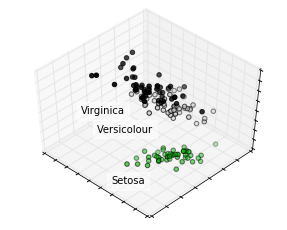

In [21]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()


for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

## Autoencoders

We can also create embeddings for multidimensional data using autoencoders.

Autoencoders model the function f, where f(x) = x

Autoencoders have a "bottleneck" part where data is reduced to a low dimensional representation and then expanded back into the same dimension as the one we've started from.

The "bottleneck" output will be our encoding. 

We're going to use the MNIST dataset as well, to model what we've just said.

ETL... again

In [30]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [38]:
X = np.expand_dims(x_train, -1)
print(X.shape)

X_val = np.expand_dims(x_test, -1)

from keras.utils.np_utils import to_categorical
y = to_categorical(y_train)
y_val = to_categorical(y_test)

(60000, 28, 28, 1)


(60000, 28, 28)


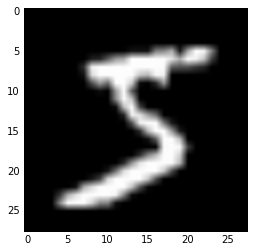

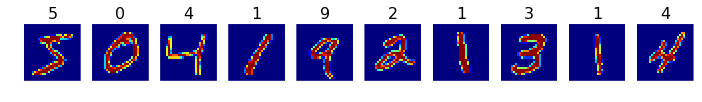

In [39]:
# Data shape
print(x_train.shape)

# show raw pixels
plt.imshow(x_train[0], cmap='gray')

# plot the first 10 images
plots(x_train[:10], titles=y_train[:10])

The model that we are going to create will look as follows

![image.png](https://cdn-images-1.medium.com/max/1600/1*MMRDQ4g3QvQNc7iJsKM9pg@2x.png)

In [61]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model

input_img = Input(shape=(28, 28, 1))

# -----------
# The encoder
# -----------
x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
encoded = MaxPooling2D((2, 2), border_mode='same')(x)


# at this point the representation is (4, 4, 8) i.e. 128-dimensional


# -----------
# The decoder
# -----------
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(16, 3, 3, activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_24 (InputLayer)            (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_47 (Convolution2D) (None, 28, 28, 16)    160         input_24[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_22 (MaxPooling2D)   (None, 14, 14, 16)    0           convolution2d_47[0][0]           
____________________________________________________________________________________________________
convolution2d_48 (Convolution2D) (None, 14, 14, 8)     1160        maxpooling2d_22[0][0]            
___________________________________________________________________________________________

In [70]:
autoencoder.fit(X, X,
                nb_epoch=10,
                batch_size=256,
                shuffle=True,
                validation_data=(X_val, X_val))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 79s - loss: -523.6325 - val_loss: -531.9488
Epoch 2/10
60000/60000 [==============================] - 79s - loss: -524.6607 - val_loss: -532.4966
Epoch 3/10
60000/60000 [==============================] - 81s - loss: -525.0491 - val_loss: -532.7882
Epoch 4/10
60000/60000 [==============================] - 82s - loss: -525.2669 - val_loss: -532.9055
Epoch 5/10
60000/60000 [==============================] - 78s - loss: -525.4088 - val_loss: -533.0264
Epoch 6/10
60000/60000 [==============================] - 85s - loss: -525.5086 - val_loss: -533.1522
Epoch 7/10
60000/60000 [==============================] - 79s - loss: -525.5668 - val_loss: -533.2292
Epoch 8/10
60000/60000 [==============================] - 80s - loss: -525.6431 - val_loss: -533.2739
Epoch 9/10
60000/60000 [==============================] - 85s - loss: -525.7007 - val_loss: -533.2745
Epoch 10/10
60000/60000 [=======

Let's see the reconstruction of a single example

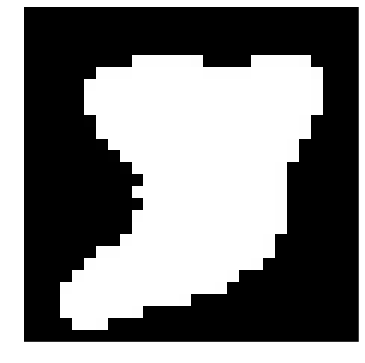

In [71]:
plots(autoencoder.predict(np.array([X[0]])))

In [66]:
encoder = Model(input_img, encoded)

In [69]:
encoder.predict(X[:1])[0].shape

(4, 4, 8)

In the end, the "embeddings" will can be mapped like this.

![image.png](https://blog.keras.io/img/ae/vae_classes_plane.png)

In [29]:
def plots(ims, figsize=(12, 6), rows=1, interp=False, titles=None, display=False):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if len(ims.shape) != 3:
            # Find out if the last dimension is not the color channel.
            # If we have K.dim_ordering('th') then the color channel is the second dimension
            # The code bellow ensures the images are in the K.dim_ordering('tf') format (channels last)
            if (ims.shape[-1] not in {1, 3}):
                # Take the color axis(1) and put it at the back(4)
                ims = ims.transpose((0, 2, 3, 1))
        else:
            # We have no color information, so no need to change the dimensions to put color on the back
            pass

    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims) // rows, i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        if ims.shape[-1] == 1:
            # Last axis is a single color channel so we can discard it and treat the data as a gray image
            plt.imshow(np.squeeze(ims[i]), interpolation=None if interp else 'none', cmap='gray')
        else:
            plt.imshow(ims[i], interpolation=None if interp else 'none')
    if display:
        return f

# Conclusions

* IDs always mean embeddings!
* NLP stands on the sholders of word2vec, glove, fasttext
* Usually, embeddings are additive

# QA

* www.clungu.com